In [ ]:
!python --version
import os
import warnings
print (os.environ['CONDA_DEFAULT_ENV'])

#suppress warnings
warnings.filterwarnings('ignore')

from dask.distributed import LocalCluster
cluster = LocalCluster()          # Fully-featured local Dask cluster
client = cluster.get_client()

client

# 1. Workbook setups

## 1.1 Import packages

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import numpy.ma as ma
import xarray as xr
xr.set_options(file_cache_maxsize=10)


import seaborn as sns

import scipy as scipy
from scipy import stats
from scipy import signal
from scipy.integrate import trapz
import math
from scipy.stats import pearsonr, spearmanr
from scipy.optimize import curve_fit

from sklearn import linear_model, datasets
from sklearn import mixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error


from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor

# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn import preprocessing

# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA

# http://scikit-learn.org/stable/modules/mixture.html
from sklearn.mixture import GaussianMixture


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.colors as colors
import cmocean.cm as cmo


import proplot as plot
import cartopy.crs as ccrs

import shapefile as shp
from shapely.geometry import Point, Polygon
import shapely
from geopy.distance import distance, Distance, lonlat
import pygplates

from matplotlib import font_manager
font_manager.findfont("TeX Gyre Heros")
mpl.rcParams.update({'font.sans-serif':'TeX Gyre Heros',
                    'font.weight': 'normal',
                    'axes.labelweight': 'normal',
                    'axes.titleweight': 'normal',
                    'pdf.fonttype':42,
                    'ps.fonttype':42
                     })

import string
import os
import requests
import io
from tqdm import tqdm
import time
import copernicusmarine

## 1.2 Miscellaneous codes

In [3]:
def _woa_variable(variable):
    '''
    codes to generate woa urls modified from https://pyoceans.github.io/python-oceans/_modules/oceans/datasets.html
    variables:
        'temperature': 't',
        'salinity': 's',
        'silicate': 'i',
        'phosphate': 'p',
        'nitrate': 'n',
        'oxygen_saturation': 'O',
        'dissolved_oxygen': 'o',
        'apparent_oxygen_utilization': 'A',
        'AOU': 'A',
        "density":"I",
        'mld':"M"
   time_periods:
        'annual': '00',
        'january': '01',
        'february': '02',
        'march': '03',
        'april': '04',
        'may': '05',
        'june': '06',
        'july': '07',
        'august': '08',
        'september': '09',
        'october': '10',
        'november': '11',
        'december': '12',
        'winter': '13',
        'spring': '14',
        'summer': '15',
        'autumn': '16',
   resolutions:
    '5': ('5deg', '5d'),
    '1': ('1.00', '01'),
    '04': ('0.25', '04'),
        

    an=Objectively analyzed climatologies are the objectively interpolated mean fields 
    for oceanographic variables at standard depth levels for the World Ocean.
    mn=The statistical mean is the average of all unflagged interpolated values at each 
    standard depth level for each variable in each 1° square which contains at least one
    '''
    _VAR = {
        'temperature': 't',
        'salinity': 's',
        'silicate': 'i',
        'phosphate': 'p',
        'nitrate': 'n',
        'oxygen_saturation': 'O',
        'oxygen': 'o',
        'apparent_oxygen_utilization': 'A',
        'AOU': 'A',
        "density":"I",
        'mld':"M02"
    }
    v = _VAR.get(variable)
    if not v:
        raise ValueError(
            f'Unrecognizable variable. Expected one of {list(_VAR.keys())}, got "{variable}".'
        )
    return v

def _woa_url(variable, time_period, resolution):
    # base = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC' ## original link from the source code
    base2 = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/'

    v = _woa_variable(variable)
    grids = {
        '5': ('5deg', '5d'),
        '1': ('1.00', '01'),
        '04': ('0.25', '04'),
    }
    
    grid = grids.get(resolution)
    if not grid:
        raise ValueError(
            f'Unrecognizable resolution. Expected one of {list(grids.keys())}, got "{resolution}".'
        )
        
    res = grid[0]
    gg = grid[1]

    time_periods = {
        'annual': '00',
        'january': '01',
        'february': '02',
        'march': '03',
        'april': '04',
        'may': '05',
        'june': '06',
        'july': '07',
        'august': '08',
        'september': '09',
        'october': '10',
        'november': '11',
        'december': '12',
        'winter': '13',
        'spring': '14',
        'summer': '15',
        'autumn': '16',
    }
    
    pref = 'woa18'
    
    time_period = time_period.lower()
    if len(time_period) == 3:
        tt = [time_periods.get(k) for k in time_periods.keys() if k.startswith(time_period)][0]
    elif len(time_period) == 2 and time_period in time_periods.values():
        tt = time_period
    else:
        tt = time_periods.get(time_period)
        

    if not tt:
        raise ValueError(
            f'Unrecognizable time_period. '
            f'Expected one of {list(time_periods.keys())}, got "{time_period}".'
        )
        
    if variable not in ['salinity', 'temperature','density','mld']:
        warnings.warn(
            f'The variable "{variable}" is only available at 1 degree resolution, '
            f'annual time period, and "{pref}".'
        )
        dddd = 'all'
   
    else:
        if variable == 'mld':
            dddd = 'decav81B0'
        elif variable == "temperature":
            dddd = 'decav'
        else:
            dddd = 'all'
    
    
    url = (
        f'{base2}'
        f'{variable}/{dddd}/{res}/'
        f'{pref}_{dddd}_{v}{tt}_{gg}.nc'  # '[PREF]_[DDDD]_[V][TT][FF][GG]' Is [FF] used?
    )            
    return url

##### WOA23 Data base url loader #############
def _woa23_url(variable, time_period, resolution):
    # base = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC' ## original link from the source code
    base_woa23 = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/'

    v = _woa_variable(variable)
    grids = {
        '5': ('5deg', '5d'),
        '1': ('1.00', '01'),
        '04': ('0.25', '04'),
    }
    
    grid = grids.get(resolution)
    if not grid:
        raise ValueError(
            f'Unrecognizable resolution. Expected one of {list(grids.keys())}, got "{resolution}".'
        )
        
    res = grid[0]
    gg = grid[1]

    time_periods = {
        'annual': '00',
        'january': '01',
        'february': '02',
        'march': '03',
        'april': '04',
        'may': '05',
        'june': '06',
        'july': '07',
        'august': '08',
        'september': '09',
        'october': '10',
        'november': '11',
        'december': '12',
        'winter': '13',
        'spring': '14',
        'summer': '15',
        'autumn': '16',
    }
    
    pref = 'woa23'
    
    time_period = time_period.lower()
    if len(time_period) == 3:
        tt = [time_periods.get(k) for k in time_periods.keys() if k.startswith(time_period)][0]
    elif len(time_period) == 2 and time_period in time_periods.values():
        tt = time_period
    else:
        tt = time_periods.get(time_period)
        

    if not tt:
        raise ValueError(
            f'Unrecognizable time_period. '
            f'Expected one of {list(time_periods.keys())}, got "{time_period}".'
        )
        
    if variable not in ['salinity', 'temperature','density','mld']:
        warnings.warn(
            f'The variable "{variable}" is only available at 1 degree resolution, '
            f'annual time period, and "{pref}".'
        )
        dddd = 'all'
   
    else:
        if variable == 'mld':
            dddd = 'decav81B0'
        elif ((variable == "temperature") or (variable == "salinity")):
            dddd = 'decav'
        else:
            dddd = 'all'
    
    
    url = (
        f'{base_woa23}'
        f'{variable}/netcdf/{dddd}/{res}/'
        f'{pref}_{dddd}_{v}{tt}_{gg}.nc'  # '[PREF]_[DDDD]_[V][TT][FF][GG]' Is [FF] used?
    )            
    return url

def round_to_nearest_half_int(num):
    return round(num * 2) / 2

def getClosestPoint_fromLineString(LineString_input,point1):
    if "MultiLineString" in str(type(LineString_input)):
        multiLineString = LineString_input
        len_multiLineString = len(multiLineString.geoms)
        idxMin = np.array([multiLineString.geoms[i].distance(point1) for i in range(len_multiLineString)]).argmin()
        
        LineString = multiLineString.geoms[idxMin]
    elif "Polygon" in str(type(LineString_input)):
        
        polygon_input = LineString_input
        LineString = polygon_input.exterior
        
    else:
        LineString = LineString_input
        
    Coords = LineString.coords
    x, y = Coords.xy

    coords_df = pd.DataFrame({'LON':x,'LAT':y})
    coords_df['LAT_diff'] = abs(point1.y-coords_df.LAT)
    coords_df['LON_diff'] = abs(point1.x-coords_df.LON)
    coords_df['LONLAT_diff_sum'] = coords_df['LAT_diff']+coords_df['LON_diff']
    lat2,lon2 = coords_df.LAT.iloc[coords_df.LONLAT_diff_sum.idxmin()],coords_df.LON.iloc[coords_df.LONLAT_diff_sum.idxmin()]
    point2 = Point(lon2,lat2)
    return point2

def distance_haversine(origin, destination, output_unit='km'):
    import math
    lon1, lat1 = origin
    lon2, lat2 = destination
    
    if output_unit=='km':
        radius = 6371
    elif output_unit=='mi':
        radius = 3956
    elif output_unit=='m':
        radius = 6371000
    
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    return d

# Define usefull functions:
def vrange(V): # Return the array value range
    return [np.min(V),np.max(V)]
def vrangec(V): # Return the array value centered range 
    xl = np.max(np.abs(vrange(V)))
    return np.array([-xl,xl])

def nonnan_gradient(array, axis=None, edge_order=1):
  """Computes the gradient of an array, ignoring NaN values.

  Args:
    array: An N-dimensional array containing samples of a scalar function.
    axis: The axis along which to compute the gradient. If None, the gradient
      is computed for all axes.
    edge_order: The order of the accuracy of the approximation at the edges of
      the array.

  Returns:
    An N-dimensional array or a list of N-dimensional arrays representing the
    gradient.
  """

  # Create a mask of non-NaN values.
  mask = np.isfinite(array)

  # Compute the gradient of the masked array.
  gradient = np.gradient(array, axis=axis, edge_order=edge_order)

  # Set the gradient to zero wherever the mask is False.
  for i in range(len(gradient)):
    gradient[i][~mask] = 0

  return gradient

## 1.3 Dictionaries

In [4]:
ringNumbers_dict_zhang16 = {
    'reported_1302':0, 
    'fGDGT_0':0,
    'reported_1300':1,
    'fGDGT_1':1, 
    'reported_1298':2,
    'fGDGT_2':2, 
    'reported_1296':3,
    'fGDGT_3':3,
    'reported_1294':4,
    'fGDGT_4':4,
    'reported_1294_iso':4,
    'fGDGT_4_prime':4,
    'reported_1292':4, 
    'fGDGT_cren':4,
    'reported_1292_iso':4,
    'fGDGT_cren_prime':4,
    'reported_1292_iso2':5,
    'fGDGT_5':5,
    'reported_1290':6,
    'fGDGT_6':6,
    'reported_1290_iso':6,
    'fGDGT_6_prime':6,
    'reported_1288':7,
    'fGDGT_7':7,
    'reported_1288_iso':7,
    'fGDGT_7_prime':7,
    'reported_1286':8,
    'fGDGT_8':8,
    'reported_1286_iso':8,
    'fGDGT_8_prime':8,
}

ringNumbers_dict_revised = {
    'reported_1302':0, 
    'fGDGT_0':0,
    'reported_1300':1,
    'fGDGT_1':1, 
    'reported_1298':2,
    'fGDGT_2':2, 
    'reported_1296':3,
    'fGDGT_3':3,
    'reported_1294':4,
    'fGDGT_4':4,
    'reported_1294_iso':4,
    'fGDGT_4_prime':4,
    'reported_1292':5, 
    'fGDGT_cren':5,
    'reported_1292_iso':5,
    'fGDGT_cren_prime':5,
    'reported_1292_iso2':5,
    'fGDGT_5':5,
    'reported_1290':6,
    'fGDGT_6':6,
    'reported_1290_iso':6,
    'fGDGT_6_prime':6,
    'reported_1288':7,
    'fGDGT_7':7,
    'reported_1288_iso':7,
    'fGDGT_7_prime':7,
    'reported_1286':8,
    'fGDGT_8':8,
    'reported_1286_iso':8,
    'fGDGT_8_prime':8,
}


def label_pvalues(x):
    if x<0.001:
        return r'$\it{p}$<.001'
    elif x<0.01:
        return r'$\it{p}$<.01'
    elif x<0.05:
        return r'$\it{p}$<.05'
    elif x<0.1:
        return r'$\it{p}$<.1'
    elif x>=0.1:
        return r'$\it{p}$>.1'


## 1.4 Set local paths

In [5]:
# set the path to local folder other than github

### 1.4.1 Local path on PC
local_documents_path = '/home/ronnie/Documents' ### this is the path when code is run on Linux

### 1.4.2 Path to github folder
gitpath_idx = os.getcwd().find('nutrient-effect-on-TEX')+len('nutrient-effect-on-TEX')
local_github_path = os.getcwd()[:gitpath_idx]

### 1.4.3 Path to OneDrive folder
local_onedrive_path = '/home/ronnie/OneDrive'

# 2. Import data

## 2.1 Coretop compilation

In [ ]:
fpath = os.path.join(local_github_path,'spreadsheets')
fname = r'texmarine-revised-2024.csv'

coretop_df = pd.read_csv(os.path.join(fpath,fname))

coretop_df = coretop_df.rename(
    columns={
        'latitude':'Latitude',
        'longitude':'Longitude',
        'depth':'modernWaterDepth',
        'tex86':'TEX86',
        'bit':'BIT'
    }
)

#### Additional parameters
coretop_df['publicationYear'] = [int(row[-4:]) if row[-4:].isdigit() else 'This Study' for row in coretop_df['reference_name']]

features = ['fGDGT_0', 'fGDGT_1', 'fGDGT_2', 'fGDGT_3','fGDGT_cren', 'fGDGT_cren_prime']
coretop_df['RI_zhang16'] = np.array([coretop_df[features[i]]*ringNumbers_dict_zhang16.get(features[i]) for i in range(len(features))]).sum(axis=0)
coretop_df['RI_zhang16_revised'] = np.array([coretop_df[features[i]]*ringNumbers_dict_revised.get(features[i]) for i in range(len(features))]).sum(axis=0)


features2 = ['fGDGT_0', 'fGDGT_1', 'fGDGT_2', 'fGDGT_3','fGDGT_cren', 'fGDGT_cren_prime']
coretop_df['RI_0to5'] = np.array([coretop_df[features2[i]]*ringNumbers_dict_revised.get(features2[i]) for i in range(len(features2))]).sum(axis=0)

coretop_df['gdgt23ratio'] = coretop_df['fGDGT_2']/coretop_df['fGDGT_3']
coretop_df['methaneIndex'] = coretop_df[['fGDGT_1', 'fGDGT_2', 'fGDGT_3']].sum(axis=1)/coretop_df[['fGDGT_1', 'fGDGT_2', 'fGDGT_3','fGDGT_cren', 'fGDGT_cren_prime']].sum(axis=1)
coretop_df['gdgtZeroOverZeroCren'] = (coretop_df['fGDGT_0']/coretop_df[['fGDGT_0','fGDGT_cren']].sum(axis=1))

temp_sampleID = ['TEXAS_PSM_RR'+str(i).zfill(5) for i in range(1,len(coretop_df)+1)]
coretop_df.insert(0,'sampleID',temp_sampleID)

#### copy coretop_df to coretop_df2 to keep the original df
coretop_df2 = coretop_df.dropna(how='any', subset=['TEX86','fGDGT_0']).reset_index(drop=True)
coretop_df2['BIT'] = coretop_df2['BIT'].fillna(-999)
coretop_df2['methaneIndex']= coretop_df2['methaneIndex'].fillna(-999)
coretop_df2['gdgtZeroOverZeroCren'] = coretop_df2['fGDGT_0'].fillna(-999)


coretop_df2['QC_flag'] = ['include' if ((coretop_df2['BIT'].iloc[i] <= 0.5) & (coretop_df2['methaneIndex'].iloc[i] <= 0.5) & (coretop_df2['gdgtZeroOverZeroCren'].iloc[i] <= 0.67)) else 'exclude' for i in range(len(coretop_df2))]
coretop_df2

## 2.2 Ocean products

### 2.2.1 WOA23 - Temperature 0.25deg x 0.25deg

WOA = World Ocean Atlas
Details:
- Temperature - Statistical mean on 1/4° grid for 1971-2000 climate normal
- Unit: Degree Celcius
- Link to download data: https://www.ncei.noaa.gov/thredds-ocean/fileServer/woa23/DATA/temperature/netcdf/decav71A0/0.25/woa23_decav71A0_t00_04.nc

In [ ]:
fpath2 = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/WOA-decav'
ts = xr.open_dataset(os.path.join(fpath2,'woa23_decav71A0_t00_01.nc'),decode_times=False).drop('time')

T_da_01 = ts.isel(time=0).t_an.load()
T_da_01


In [ ]:
fpath2 = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/WOA-decav'
ts = xr.open_dataset(os.path.join(fpath2,'woa23_decav71A0_t00_04.nc'),decode_times=False).drop('time')

T_da = ts.isel(time=0).t_an.load()
T_da

In [ ]:
fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/calculated-properties'
fname = 'WOA23_mingrad_thermocline_integral_04degReso_revised.nc'
thermocline_T_integral_da = xr.open_dataset(os.path.join(fpath,fname),decode_times=False).thermo_integral.load()
thermocline_T_integral_da

In [ ]:
fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/calculated-properties'
fname = 'WOA23_mingrad_thermocline_depth_04degReso_revised.nc'

thermocline_depth_da = xr.open_dataset(os.path.join(fpath,fname),decode_times=False).thermo_depth.load()
thermocline_depth_da

#### Calculate gridded thermocline depth and depth-integrated thermocline T with xarray

In [11]:
### calculate thermocline along depth dimension of T_da using min T gradient approach (depth with the fastest drop in T)
### calculate using diff method from xarray and divide by the diff of depth
sliced_T_da = T_da.sel(depth=slice(0,1100))
gradient = sliced_T_da.diff('depth')/sliced_T_da.depth.diff('depth')

### mask NaN values
gradient = abs(gradient.where(~np.isnan(T_da)))

### fill NaN values with infinity to avoid error in argmin
gradient_filled = gradient.fillna(-np.inf)
maxabs_gradient_idx = gradient_filled.argmax('depth',skipna=True).astype(int)+1

### mask locations where all depth values are NaN
all_nan_mask = np.isnan(sliced_T_da).all('depth')

### mask maxabs_gradient_idx where all depth values are NaN
maxabs_gradient_idx = maxabs_gradient_idx.where(~all_nan_mask, drop=False)

# Flatten the lat-lon grid for advanced indexing
stacked = sliced_T_da.stack(grid=["lat", "lon"])

# Ensure maxabs_gradient_idx is an integer, replacing NaN with a valid placeholder index (e.g., 0)
valid_idx = maxabs_gradient_idx.fillna(0).astype(int)

# Use isel to index the depth dimension with the flattened indices
thermoT_depth_values = stacked["depth"].isel(depth=valid_idx.stack(grid=["lat", "lon"]))
thermoT_values = stacked.isel(depth=valid_idx.stack(grid=["lat", "lon"]))
# Mask locations where maxabs_gradient_idx was NaN
nan_mask = maxabs_gradient_idx.isnull()
thermoT_depth_values = thermoT_depth_values.where(~nan_mask.stack(grid=["lat", "lon"]))
thermoT_values = thermoT_values.where(~nan_mask.stack(grid=["lat", "lon"]))
# Unstack to return to the original lat-lon dimensions
thermoT_depth_da = thermoT_depth_values.unstack("grid")
thermoT_da = thermoT_values.unstack("grid")
masked_T_da = T_da.where(T_da["depth"]<=thermoT_depth_da)


In [ ]:
len_notnull_values_along_depth = np.unique(masked_T_da.notnull().sum('depth').values)
sel_masked_da = masked_T_da
tmp_da = xr.DataArray(np.zeros_like(sel_masked_da.isel(depth=0).values),
                      dims=sel_masked_da.isel(depth=0).dims,
                      coords=sel_masked_da.isel(depth=0).coords
                      )
tmp_da
# Loop through the unique counts of non-NaN values along depth
for i in len_notnull_values_along_depth:
    if i == 0:
        continue  # Skip cases where no valid data is available
    # Select grid points where the non-NaN count equals `i`
    mask = sel_masked_da.notnull().sum('depth') == i
    
    if i == 1:
        # if only one valid depth slice, use the first depth slice
        cal_values = (
            sel_masked_da.where(sel_masked_da.notnull().sum('depth') == i)
            .isel(depth=0)
        )
    else:
        # Calculate the integrated values for the valid depth slices
        cal_values = (
            sel_masked_da.where(sel_masked_da.notnull().sum('depth') == i)
            .isel(depth=slice(0, i))
            .integrate('depth')
        )
        
        # Update tmp_da with the calculated values at the same grid points
    tmp_da = tmp_da.where(~mask, other=cal_values)
tmp_da2 = tmp_da
#### mask locations where there are more than 1 valid depth values
mask_below_SST = sel_masked_da.notnull().sum('depth') > 1
cal_values = tmp_da2.where(mask_below_SST)/thermoT_depth_da.where(mask_below_SST)
# apply mask where all depth values are NaN
all_nan_mask = np.isnan(sel_masked_da).all('depth')
tmp_da2 = tmp_da2.where(~all_nan_mask)

thermocline_depthIntegral_T_da = tmp_da2.where(~mask_below_SST, other=cal_values)
thermocline_depthIntegral_T_da

In [ ]:
fig, axs = plot.subplots(proj='robin',width=10,nrows=3,ncols=2)
ax = axs[0,0]

m = thermocline_depthIntegral_T_da.plot(ax=ax,
                        cmap='cmo.thermal',
                        add_colorbar=False,
                        levels=np.arange(-4,31,2),
                        )
ax.colorbar(m, loc='b', label='Temperature (\N{DEGREE SIGN}C)',
            ticks=np.arange(-4,31,4),
            tickminor=False,
            )

ax = axs[0,1]
m = thermoT_depth_da.plot(ax=ax,
                cmap='cmo.deep',
                add_colorbar=False,
                levels=np.arange(0,500,50),
                )
ax.colorbar(m, loc='b', label='Depth (m)',
            ticks=np.arange(0,500,50),
            tickminor=False,
            )



### add contour line of 28 degree isotherm of the calculated thermocline dataarray
ax = axs[1,0]
m=thermocline_T_integral_da.plot(ax=ax,
                                cmap='cmo.thermal',
                                levels=np.arange(-4,31,2),
                                add_colorbar=False,
                                )
ax.colorbar(m, loc='b', label='Temperature (\N{DEGREE SIGN}C)',
            ticks=np.arange(-4,31,4),
            tickminor=False,
            )

ax = axs[1,1]
m=thermocline_depth_da.plot(ax=ax,
                            cmap='cmo.deep',
                            levels=np.arange(0,500,50),
                            add_colorbar=False,
                            )
ax.colorbar(m, loc='b', label='Depth (m)',
            ticks=np.arange(0,500,50),
            tickminor=False,
            )
#########################################3
ax = axs[2,0]
diff = thermocline_depthIntegral_T_da-thermocline_T_integral_da
m = diff.plot(ax=ax,
              cmap='cmo.balance',
              levels=np.arange(-10,10,1),
              add_colorbar=False,
              )
ax.colorbar(m,label='Temperature (\N{DEGREE SIGN}C)',loc='b',
            ticks=np.arange(-10,10,1),
            tickminor=False,
            )

ax = axs[2,1]
depth_diff = thermoT_depth_da-thermocline_depth_da
m = depth_diff.plot(ax=ax,
                    cmap='cmo.balance',
                    levels=np.arange(-50,50,5),
                    add_colorbar=False,
                    )
ax.colorbar(m,label='Depth (m)',loc='b',
            ticks=np.arange(-50,50,5),
            tickminor=False,
            )

In [ ]:
fig, axs = plot.subplots(proj='robin',width=10,ncols=2)
axs.format(
    latlim=(15,20),
    lonlim=(35,45),
    latlabels=True,lonlabels=True
)

ax = axs[0]
thermocline_depthIntegral_T_da.plot(ax=ax,robust=True,
                                    cmap=cmo.thermal,
                                    levels=np.arange(-4,30,2),
                                    cbar_kwargs={'label':'Temperature (°C)'}
                                    )

ax.scatter(coretop_df2['Longitude'],coretop_df2['Latitude'],s=10,c='k',marker='x',label='Coretops')

ax = axs[1]
thermoT_depth_da.plot(ax=ax,robust=True,
                cmap=cmo.deep,
                levels=np.arange(0,200,10),
                cbar_kwargs={'label':'Depth (m)'}
                )

ax.scatter(coretop_df2['Longitude'],coretop_df2['Latitude'],s=10,c='k',marker='x',label='Coretops')
ax.scatter(41,18)

In [ ]:
fig, axs = plot.subplots(nrows=3,proj='cyl',width=6)
axs.format(latlim=(0,4),lonlim=(115,120),
           latlabels=True,lonlabels=True,)

ax = axs[0]
aa = T_da.isel(depth=0)
m = aa.plot(ax=ax,
            levels=np.arange(-4,31,2),
            cmap='cmo.thermal',
            add_colorbar=False,
            )
ax.colorbar(m, loc='r', label='Temperature (\N{DEGREE SIGN}C)',
            ticks=np.arange(-4,31,4),
            tickminor=False,
            )

ax = axs[1]

bb = thermoT_depth_da
m = bb.plot(ax=ax,
            # levels=np.arange(-4,31,2),
            cmap='cmo.deep',
            add_colorbar=False,
            )
ax.colorbar(m, loc='r', 
            # label='Temperature (\N{DEGREE SIGN}C)',
            # ticks=np.arange(-4,31,4),
            tickminor=False,
            )

ax = axs[2]
cc = thermocline_depthIntegral_T_da
m = cc.plot(ax=ax,
            levels=np.arange(-4,31,2),
            add_colorbar=False,
            )
ax.colorbar(m, loc='r', label='Temperature (\N{DEGREE SIGN}C)',
            ticks=np.arange(-4,31,2),
            tickminor=False,
            )

axs.scatter(
    coretop_df2['Longitude'],coretop_df2['Latitude'],s=10,c='k',marker='x',label='Coretops'
)

axs.scatter(117.6,3.125)

In [ ]:
T_da.sel(lon=117.5,lat=3.1,method='nearest').dropna('depth').integrate('depth')

### 2.2.2 CMEMS Nitrate

CMEMS = Copernicus Marine Environmental Monitoring Service

- Nitrate - Mole concentration of nitrate in sea water 0.25deg x 0.25deg
- Unit: mmol/m3
- Link to data product website: https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_BGC_001_029/description

- Raw data: monthly climatology hindcasts from 1993-2022 (30 years)
- Processing: The climatology mean field of annual average were generated from 30-year montly climatologies using ncclimo function (https://nco.sourceforge.net/nco.html)

In [ ]:
### NEMO nitrate data
fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/Marine-Copernicus-Service/processed-files/Global-Biogeochemistry/climo-monthly/no3'
fname = r'mercatorfreebiorys2v4_global_mean_ANN_199301_202212_climo.nc'

nitrate_CMEMS_ds = xr.open_dataset(os.path.join(fpath,fname))
nitrate_CMEMS_ds = nitrate_CMEMS_ds.isel(time=0).drop('time')
nitrate_CMEMS_ds = nitrate_CMEMS_ds.rename({'latitude':'lat','longitude':'lon'})
nitrate_CMEMS_da = nitrate_CMEMS_ds.no3.load() ### convert mmol/L to umol/L to make it comparable to WOA data
nitrate_CMEMS_da

depth_coord = nitrate_CMEMS_da.depth
depth_coord = depth_coord - depth_coord[0]
nitrate_CMEMS_da = nitrate_CMEMS_da.assign_coords(depth=depth_coord)
nitrate_CMEMS_da

In [ ]:
### regrid nitrate_CMESM to T_an grid
nitrate_CMEMS_da_regrid_ll = nitrate_CMEMS_da.interp(lat=T_da.lat,lon=T_da.lon,method='linear')
display(nitrate_CMEMS_da_regrid_ll)

nitrate_CMEMS_da_regrid_lld = nitrate_CMEMS_da.interp(lat=T_da.lat,lon=T_da.lon,depth=T_da.depth,method='linear')
nitrate_CMEMS_da_regrid_lld 

In [ ]:
masked_nitrate_regrid_lld_da = nitrate_CMEMS_da_regrid_lld.where(nitrate_CMEMS_da_regrid_lld["depth"]<=thermoT_depth_da)
masked_tmp_grid = masked_nitrate_regrid_lld_da
len_notnull_values_along_depth = np.unique(masked_tmp_grid.notnull().sum('depth').values)
tmp_da = xr.DataArray(np.zeros_like(masked_tmp_grid.isel(depth=0).values),
                      dims=masked_tmp_grid.isel(depth=0).dims,
                      coords=masked_tmp_grid.isel(depth=0).coords
                      )
tmp_da2 = xr.DataArray(np.zeros_like(masked_tmp_grid.isel(depth=0).values),
                        dims=masked_tmp_grid.isel(depth=0).dims,
                        coords=masked_tmp_grid.isel(depth=0).coords
                        )
# Loop through the unique counts of non-NaN values along depth
for i in len_notnull_values_along_depth:
    if i == 0:
        continue  # Skip cases where no valid data is available
    # Select grid points where the non-NaN count equals `i`
    mask = masked_tmp_grid.notnull().sum('depth') == i
    
    if i == 1:
        # if only one valid depth slice, use the first depth slice
        cal_values = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=0)
        )
        cal_values2 = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=0)
        )
    else:
        # Calculate the integrated values for the valid depth slices
        cal_values = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=slice(0, i))
            .integrate('depth')
        )
        ### grab last value of nitrate
        cal_values2 = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=slice(0, i))
            .isel(depth=i-1)
        )
    # Update tmp_da with the calculated values at the same grid points
    tmp_da = tmp_da.where(~mask, other=cal_values)
    tmp_da2 = tmp_da2.where(~mask, other=cal_values2)

#### mask locations where there are more than 1 valid depth values
mask_below_surface = masked_tmp_grid.notnull().sum('depth') > 1
cal_values = tmp_da.where(mask_below_surface)/thermoT_depth_da.where(mask_below_surface)

# apply mask where all depth values are NaN
all_nan_mask = np.isnan(masked_tmp_grid).all('depth')
tmp_da = tmp_da.where(~all_nan_mask)
thermocline_depthIntegral_nitrate_da = tmp_da
thermocline_depthIntegral_nitrate_da = thermocline_depthIntegral_nitrate_da.where(~mask_below_surface, other=cal_values)
display(thermocline_depthIntegral_nitrate_da)

tmp_da2 = tmp_da2.where(~all_nan_mask)
thermocline_nitrate_da = tmp_da2
display(thermocline_nitrate_da)


### 2.2.3 WOA23 Nitrate

In [ ]:
### WOA23 nitrate data
fpath2 = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/WOA-decav'
fname = r'woa23_all_n00_01.nc'

nitrate_WOA23_da = xr.open_dataset(os.path.join(fpath2,fname),decode_times=False).n_an.load()
nitrate_WOA23_da

In [21]:
### calculate thermocline along depth dimension of T_da using min T gradient approach (depth with the fastest drop in T)
### calculate using diff method from xarray and divide by the diff of depth
sel_T_da = T_da_01
sliced_T_da = sel_T_da.sel(depth=slice(0,1100))
gradient = sliced_T_da.diff('depth')/sliced_T_da.depth.diff('depth')

### mask NaN values
gradient = abs(gradient.where(~np.isnan(sel_T_da)))

### fill NaN values with infinity to avoid error in argmin
gradient_filled = gradient.fillna(-np.inf)
maxabs_gradient_idx = gradient_filled.argmax('depth',skipna=True).astype(int)+1

### mask locations where all depth values are NaN
all_nan_mask = np.isnan(sliced_T_da).all('depth')

### mask maxabs_gradient_idx where all depth values are NaN
maxabs_gradient_idx = maxabs_gradient_idx.where(~all_nan_mask, drop=False)

# Flatten the lat-lon grid for advanced indexing
stacked = sliced_T_da.stack(grid=["lat", "lon"])

# Ensure maxabs_gradient_idx is an integer, replacing NaN with a valid placeholder index (e.g., 0)
valid_idx = maxabs_gradient_idx.fillna(0).astype(int)

# Use isel to index the depth dimension with the flattened indices
thermoT_01_depth_values = stacked["depth"].isel(depth=valid_idx.stack(grid=["lat", "lon"]))
thermoT_01_values = stacked.isel(depth=valid_idx.stack(grid=["lat", "lon"]))
# Mask locations where maxabs_gradient_idx was NaN
nan_mask = maxabs_gradient_idx.isnull()
thermoT_01_depth_values = thermoT_01_depth_values.where(~nan_mask.stack(grid=["lat", "lon"]))
thermoT_01_values = thermoT_01_values.where(~nan_mask.stack(grid=["lat", "lon"]))
# Unstack to return to the original lat-lon dimensions
thermoT_01_depth_da = thermoT_01_depth_values.unstack("grid")
thermoT_01_da = thermoT_01_values.unstack("grid")



In [ ]:
masked_nitrate_WOA23 = nitrate_WOA23_da.where(nitrate_WOA23_da["depth"]<=thermoT_01_depth_da)
masked_tmp_grid = masked_nitrate_WOA23
len_notnull_values_along_depth = np.unique(masked_tmp_grid.notnull().sum('depth').values)
tmp_da = xr.DataArray(np.zeros_like(masked_tmp_grid.isel(depth=0).values),
                      dims=masked_tmp_grid.isel(depth=0).dims,
                      coords=masked_tmp_grid.isel(depth=0).coords
                      )
tmp_da2 = xr.DataArray(np.zeros_like(masked_tmp_grid.isel(depth=0).values),
                        dims=masked_tmp_grid.isel(depth=0).dims,
                        coords=masked_tmp_grid.isel(depth=0).coords
                        )
# Loop through the unique counts of non-NaN values along depth
for i in len_notnull_values_along_depth:
    if i == 0:
        continue  # Skip cases where no valid data is available
    # Select grid points where the non-NaN count equals `i`
    mask = masked_tmp_grid.notnull().sum('depth') == i
    
    if i == 1:
        # if only one valid depth slice, use the first depth slice
        cal_values = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=0)
        )
        cal_values2 = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=0)
        )
    else:
        # Calculate the integrated values for the valid depth slices
        cal_values = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=slice(0, i))
            .integrate('depth')
        )
        ### grab last value of nitrate
        cal_values2 = (
            masked_tmp_grid.where(masked_tmp_grid.notnull().sum('depth') == i)
            .isel(depth=slice(0, i))
            .isel(depth=i-1)
        )
    # Update tmp_da with the calculated values at the same grid points
    tmp_da = tmp_da.where(~mask, other=cal_values)
    tmp_da2 = tmp_da2.where(~mask, other=cal_values2)

#### mask locations where there are more than 1 valid depth values
mask_below_surface = masked_tmp_grid.notnull().sum('depth') > 1
cal_values = tmp_da.where(mask_below_surface)/thermoT_01_depth_da.where(mask_below_surface)

# apply mask where all depth values are NaN
all_nan_mask = np.isnan(masked_tmp_grid).all('depth')
tmp_da = tmp_da.where(~all_nan_mask)
WOA23_thermocline_depthIntegral_nitrate_da = tmp_da
WOA23_thermocline_depthIntegral_nitrate_da = WOA23_thermocline_depthIntegral_nitrate_da.where(~mask_below_surface, other=cal_values)
display(WOA23_thermocline_depthIntegral_nitrate_da)
tmp_da2 = tmp_da2.where(~all_nan_mask)
WOA23_thermocline_nitrate_da = tmp_da2
display(WOA23_thermocline_nitrate_da)


In [ ]:
array = [
    [1,2],
    [3,4],
]
fig, axs = plot.subplots(
    array,
    proj=('robin','robin',None),
    figsize=(8,8),
    share=False)
ax = axs[0,0]
m = T_da.sel(depth=100,method='nearest').plot(ax=ax,
                        levels=np.arange(-4,31,2),
                        cmap='cmo.thermal',
                        add_colorbar=False,
                        )
ax.colorbar(m, loc='b', label='Temperature (\N{DEGREE SIGN}C)',
            ticks=np.arange(-4,31,4),
            tickminor=False,
            )

### plot lon line at -30
ax.plot([-30,-30],[-90,90],'k--',lw=1)

ax = axs[0,1]
m = nitrate_CMEMS_da_regrid_lld.sel(depth=100,method='nearest').plot(ax=ax,
                        robust=True,
                        cmap='cmo.matter_r',
                        add_colorbar=False,
                        levels=[1e-4,1e-3,1e-2,1e-1,1,10,100],
                        )
ax.colorbar(m, loc='b', label='Nitrate ($\mu$mol/L)',
            ticks=[1e-4,1e-3,1e-2,1e-1,1,10,100],
            tickminor=False,
            )


ax = axs[1,0]
plot_x = T_da.where(T_da["lat"]<0).sel(depth=100,method='nearest').values.flatten()
plot_y = nitrate_CMEMS_da_regrid_lld.where(nitrate_CMEMS_da_regrid_lld["lat"]<0).sel(depth=100,method='nearest').values.flatten()
nonnan_idx = np.where((~np.isnan(plot_x)) & (~np.isnan(plot_y)))
plot_x = plot_x[nonnan_idx]
plot_y = plot_y[nonnan_idx]
plot_lat = T_da.where(T_da["lat"]<0).sel(depth=100,method='nearest').to_dataframe().reset_index()['lat'].values[nonnan_idx]

m = ax.scatter(plot_x,plot_y,m='.',c=plot_lat,cmap='Balance',s=5,
               levels=np.arange(-90,91,10),
)
ax.format(xlabel='Temperature (\N{DEGREE SIGN}C)',ylabel='Nitrate ($\mu$mol/L)',
          yscale='log',xscale='linear',)
ax.colorbar(m,label='Latitude ($^\circ$)',loc='r')
### calculate the correlation coefficient
rho, pval = spearmanr(plot_x,plot_y)

ax.text(0.025,0.025,f'$\\rho$: {rho:.4f}\np: {pval:.4f}',transform=ax.transAxes,ha='left',va='bottom')

ax = axs[1,1]
plot_x = T_da.where(T_da["lat"]>0).sel(depth=100,method='nearest').values.flatten()
plot_y = nitrate_CMEMS_da_regrid_lld.where(nitrate_CMEMS_da_regrid_lld["lat"]>0).sel(depth=100,method='nearest').values.flatten()
nonnan_idx = np.where((~np.isnan(plot_x)) & (~np.isnan(plot_y)))
plot_x = plot_x[nonnan_idx]
plot_y = plot_y[nonnan_idx]
plot_lat = T_da.where(T_da["lat"]>0).sel(depth=100,method='nearest').to_dataframe().reset_index()['lat'].values[nonnan_idx]

m = ax.scatter(plot_x,plot_y,m='.',c=plot_lat,cmap='Balance',s=5,
               levels=np.arange(-90,91,10),
)
ax.format(xlabel='Temperature (\N{DEGREE SIGN}C)',ylabel='Nitrate ($\mu$mol/L)',
          yscale='log',xscale='linear',)
ax.colorbar(m,label='Latitude ($^\circ$)',loc='r')
### calculate the correlation coefficient
rho, pval = spearmanr(plot_x,plot_y)

ax.text(0.025,0.025,f'$\\rho$: {rho:.4f}\np: {pval:.4f}',transform=ax.transAxes,ha='left',va='bottom')

In [ ]:
fig, axs = plot.subplots(nrows=3,figsize=(8,6))
sel_lon = -30
ax = axs[0]
nitrate_CMEMS_da.sel(lon=sel_lon,method='nearest').plot(ax=ax)

ax = axs[1]
nitrate_CMEMS_da_regrid_ll.sel(lon=sel_lon,method='nearest').plot(ax=ax)

ax = axs[2]
nitrate_CMEMS_da_regrid_lld.sel(lon=sel_lon,method='nearest').plot(ax=ax)

axs.format(
    yreverse=True,
)

In [25]:
thermocline_depthIntegral_nitrate_da = thermocline_depthIntegral_nitrate_da.rename('thermocl_depthIntg_nitrate')
thermocline_nitrate_da = thermocline_nitrate_da.rename('thermocl_nitrate')
WOA23_thermocline_depthIntegral_nitrate_da = WOA23_thermocline_depthIntegral_nitrate_da.rename('thermocl_depthIntg_nitrate')
WOA23_thermocline_nitrate_da = WOA23_thermocline_nitrate_da.rename('thermocl_nitrate')
thermocline_depthIntegral_T_da = thermocline_depthIntegral_T_da.rename('thermocl_depthIntg_T')
thermoT_depth_da = thermoT_depth_da.rename('thermocl_depth')
thermoT_da = thermoT_da.rename('thermocl_T')

In [26]:
# #### save all calculated dataarrays to netcdf
# fpath = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/calculated-properties'

# fname = 'CMEMS_thermocline_nitrate_integral_011625.nc'
# thermocline_depthIntegral_nitrate_da.to_netcdf(os.path.join(fpath,fname))

# fname = 'CMEMS_thermocline_nitrate_011625.nc'
# thermocline_nitrate_da.to_netcdf(os.path.join(fpath,fname))

# fname = 'WOA23_thermocline_nitrate_integral_011625.nc'
# WOA23_thermocline_depthIntegral_nitrate_da.to_netcdf(os.path.join(fpath,fname))

# fname = 'WOA23_thermocline_nitrate_011625.nc'
# WOA23_thermocline_nitrate_da.to_netcdf(os.path.join(fpath,fname))

# fname = 'WOA23_thermocline_depthIntegral_T_011625.nc'
# thermocline_depthIntegral_T_da.to_netcdf(os.path.join(fpath,fname))

# fname = 'WOA23_thermocline_depth_011625.nc'
# thermoT_depth_da.to_netcdf(os.path.join(fpath,fname))

# fname = 'WOA23_thermocline_T_011625.nc'
# thermoT_da.to_netcdf(os.path.join(fpath,fname))

# 3. Pre-processing

## 3.0 Match gridded lat, lon, depth

In [27]:
mid_lat_array = T_da.lat.values
mid_lon_array = T_da.lon.values
depth_array = T_da.depth.values
coretop_df2['match_lat'] = [mid_lat_array[np.abs(mid_lat_array-row).argmin()] for row in coretop_df2['Latitude']]
coretop_df2['match_lon'] = [mid_lon_array[np.abs(mid_lon_array-row).argmin()] for row in coretop_df2['Longitude']]
coretop_df2['match_depth'] = [depth_array[np.abs(depth_array-row).argmin()] for row in coretop_df2['modernWaterDepth']]

## 3.1 Temperature and thermoclines

In [ ]:
##### Calculated clines depth and integrated and weighted integral values
coretop_df2['SST'] = [T_da.isel(depth=0).sel(lat=coretop_df2['Latitude'].iloc[i],lon=coretop_df2['Longitude'].iloc[i],
                               method='nearest').values for i in range(len(coretop_df2))]
coretop_df2['thermocline_depth'] = [thermoT_depth_da.sel(lat=coretop_df2['Latitude'].iloc[i],lon=coretop_df2['Longitude'].iloc[i],
                                 method='nearest').values for i in range(len(coretop_df2))]
coretop_df2['thermocline_T'] = [thermoT_da.sel(lat=coretop_df2['Latitude'].iloc[i],lon=coretop_df2['Longitude'].iloc[i],
                                 method='nearest').values for i in range(len(coretop_df2))]
coretop_df2['thermocline_T_depthIntegral'] = [thermocline_depthIntegral_T_da.sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                                lon=coretop_df2['Longitude'].iloc[i],
                                                                                method='nearest').values for i in range(len(coretop_df2))]
    
coretop_df2

## 3.2 Nitrate concentrations

In [ ]:
### calculate integrated nitrate values to the thermocline depth
coretop_df2['SSN'] = [nitrate_CMEMS_da_regrid_lld.isel(depth=0).sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                    lon=coretop_df2['Longitude'].iloc[i],
                                                                    method='nearest').values for i in range(len(coretop_df2))]

coretop_df2['thermocline_nitrate'] = [thermocline_nitrate_da.sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                lon=coretop_df2['Longitude'].iloc[i],
                                                                method='nearest').values for i in range(len(coretop_df2))]
coretop_df2['thermocline_nitrate_depthIntegral'] = [thermocline_depthIntegral_nitrate_da.sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                                            lon=coretop_df2['Longitude'].iloc[i],
                                                                                            method='nearest').values for i in range(len(coretop_df2))]

coretop_df2

In [ ]:
### calculate integrated nitrate values to the thermocline depth
coretop_df2['WOA23_SSN'] = [nitrate_WOA23_da.isel(depth=0).sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                lon=coretop_df2['Longitude'].iloc[i],
                                                                method='nearest').values[0] for i in range(len(coretop_df2))]
coretop_df2['WOA23_thermocline_nitrate'] = [WOA23_thermocline_nitrate_da.sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                            lon=coretop_df2['Longitude'].iloc[i],
                                                                            method='nearest').values[0] for i in range(len(coretop_df2))]
coretop_df2['WOA23_thermocline_nitrate_depthIntegral'] = [WOA23_thermocline_depthIntegral_nitrate_da.sel(lat=coretop_df2['Latitude'].iloc[i],
                                                                                                        lon=coretop_df2['Longitude'].iloc[i],
                                                                                                        method='nearest').values[0] for i in range(len(coretop_df2))]

coretop_df2

## 3.3 Hand-labelling region name

In [ ]:
##### Load spreadsheet with manually-assigned region names for coretops
fpath = os.path.join(local_github_path,'spreadsheets')
fname = 'manual_regionName_assignment_010425'
manual_regionName_df = pd.read_excel(os.path.join(fpath,fname+'.xlsx'),sheet_name='master_regionName')
manual_regionName_df = manual_regionName_df.rename(columns={'Sample ID':'sampleID',
                                                            'region_description':'regionName'})

coretop_df_full = pd.concat([coretop_df2.set_index('sampleID'),
                             manual_regionName_df.set_index('sampleID')],axis=1).reset_index(drop=False).dropna(subset=['core_name'])
coretop_df_full = coretop_df_full.loc[:,~coretop_df_full.columns.duplicated()]
coretop_df_full

In [ ]:
import matplotlib.colors as mcolors
##### concatenate three colormaps

colors1 = plot.get_colors('tab10')
colors2 = plot.get_colors('tab20b')
colors3 = plot.get_colors('538')
colors4 = plot.get_colors('tab20c')
colors5 = plot.get_colors('bmh')

combined_cmap = np.concatenate((colors1,colors2,colors3,colors4,colors5))
extended_cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap',combined_cmap)
#########
region_list_full = coretop_df_full['regionName'].unique()
color_list_full = plot.get_colors(extended_cmap,len(region_list_full))

region_color_dict_full = dict(zip(region_list_full,color_list_full))
region_color_dict_full

region_color_dict_full_rgb = {k:mpl.colors.to_rgba(v) for k,v in region_color_dict_full.items()}
region_color_dict_full_rgb

## 3.4 Additional indices

In [33]:
### additional indices

coretop_df_full['TEX_RI_zhang16'] = (-0.77*coretop_df_full['TEX86']
                                )+(3.32*coretop_df_full['TEX86']**2
                                   )+(1.59)
coretop_df_full['deltaRI_zhang16'] = coretop_df_full['TEX_RI_zhang16']-coretop_df_full['RI_zhang16']



### Re-evaluate TEX-RI relationship

In [ ]:
from scipy.stats import t

fig, axs = plot.subplots(width=12,
                         ncols=3,
                         nrows=2,
                         proj=('robin','robin','robin',None),
                         hratios=[1,2])
axs[0,:].format(
    land=True,landcolor='gray3',landzorder=0
)

plot_data = coretop_df_full[coretop_df_full['QC_flag']=='include']
plot_data_exclude = coretop_df_full[coretop_df_full['QC_flag']=='exclude']

m = axs[0,1].scatter(plot_data['Longitude'],plot_data['Latitude'],
               c=plot_data['deltaRI_zhang16'],
               levels=np.arange(-0.3,0.31,0.05),
               cmap='RdBu',
)
axs[0,1].colorbar(m,label='$\Delta$RI (RI$_{TEX}$ - RI$_{sample}$)',loc='b',length=0.8)

grouped = plot_data.groupby('regionName')
for region, group in grouped:
    axs[0,0].scatter(group['Longitude'],group['Latitude'],
                     c=region_color_dict_full.get(region),
                     label=region)
    axs[1,:].scatter(group['TEX86'],group['RI_zhang16'],
                   m='.',
                   c=region_color_dict_full.get(region),
                   label=region)

axs[0,0].scatter(plot_data_exclude['Longitude'],plot_data_exclude['Latitude'],
               m='x',c='k',
               label='excluded data')
axs[1,0].scatter(plot_data_exclude['TEX86'],plot_data_exclude['RI_zhang16'],
               m='x',c='k',
               label='excluded data')

data_len = len(plot_data)
axs[1,0].text(0.10,0.98,f'N={data_len}',transform=axs[1,0].transAxes)

### Zhang 2016 TEX-RI relationship
TEX_sample = np.linspace(0.2,0.9,100)
RI_sample = (-0.77*TEX_sample)+(3.32*TEX_sample**2)+1.59
RI_sample_upper = RI_sample + 0.3
RI_sample_lower = RI_sample - 0.3


axs[1,1:].plot(TEX_sample,RI_sample,c='k',lw=2,label='Zhang et al. 2016')
axs[1,1:].plot(TEX_sample,RI_sample_upper,c='k',ls='--',lw=1)
axs[1,1:].plot(TEX_sample,RI_sample_lower,c='k',ls='--',lw=1)

### write out equation
## Zhang et al. 2016
axs[1,1].text(0.95,0.05,'RI(±0.3) = -0.77 * TEX$_{86}$ + 3.32 * TEX$_{86}^2$ + 1.59\n(Zhang et al. 2016)',
            transform=axs[1,1].transAxes,
            ha='right',va='bottom')

#### OLS regression between TEX86 and RI_zhang16 for plot_data
ols = LinearRegression()
XX = plot_data['TEX86'].values.reshape(-1,1)
yy = plot_data['RI_zhang16']
ols.fit(XX,yy)
slope = ols.coef_[0]
intercept = ols.intercept_
RI_sample_ols = ols.predict(TEX_sample.reshape(-1,1))
axs[1,2].plot(TEX_sample,RI_sample_ols,c='gray7',lw=2,label='Linear (this study)',zorder=0)

#predict new RI for coretop_df_full
coretop_df_full['TEX_RI_new'] = ols.predict(coretop_df_full['TEX86'].values.reshape(-1,1))
coretop_df_full['deltaRI_new'] = coretop_df_full['TEX_RI_new']-coretop_df_full['RI_zhang16']

### plot on map
m2 = axs[0,2].scatter(coretop_df_full['Longitude'],coretop_df_full['Latitude'],
                c=coretop_df_full['deltaRI_new'],
                levels=np.arange(-0.3,0.31,0.05),
                cmap='RdBu',
    )
axs[0,2].colorbar(m2,label='$\Delta$RI (RI$_{TEX}$ - RI$_{sample}$)',loc='b',length=0.8)
### write out equation
## this study
axs[1,2].text(0.95,0.05,f'RI(±0.4903) = {slope:.3f}'+' * TEX$_{86}$ + '+f'{intercept:.3f}\n(this study)',
            transform=axs[1,2].transAxes,
            c='gray7',
            ha='right',va='bottom')

### 95% confidence interval
y_pred = ols.predict(plot_data['TEX86'].values.reshape(-1,1))
residuals = yy-y_pred
sse = np.sum(residuals**2)
n = len(plot_data)
p = XX.shape[1]
dof = n-p-1
mse = sse/dof
se = np.sqrt(mse)

### calculate critical t value
alpha = 0.05
t_value = t.ppf(1-alpha/2,dof)

### calculate confidence interval
lower_bound = RI_sample_ols - t_value*se
upper_bound = RI_sample_ols + t_value*se
axs[1,2].fill_between(TEX_sample,lower_bound,upper_bound,color='gray8',alpha=0.3,zorder=0)

### Spearman rho and p-value
rho,pval = scipy.stats.spearmanr(XX,yy)
axs[1,2].text(0.05,0.9,f'$\\rho$={rho:.2f}, p={pval:.2f} (linear-new)',
            transform=axs[1,2].transAxes)


### Calculate new deltaRI based on the revised TEX-RI relationship

- Create "QC_flag2" column by adding deltaRI_new condition

In [35]:
coretop_df_full['QC_flag2'] = np.nan
for i in range(len(coretop_df_full)):
    if coretop_df_full['QC_flag'].iloc[i]=='include':
        if abs(coretop_df_full['deltaRI_new'].iloc[i])<0.4903:
            coretop_df_full['QC_flag2'].iloc[i] = 'include'
        else:
            coretop_df_full['QC_flag2'].iloc[i] = 'exclude'
    else:
        coretop_df_full['QC_flag2'].iloc[i] = 'exclude'

In [ ]:
import plotly.express as px

# Create a scatter plot
plot_data = coretop_df_full[coretop_df_full['QC_flag']=='include']
fig = px.scatter_geo(plot_data, lon='Longitude', lat='Latitude', color='regionName',
                     labels={'Latitude':'Latitude','Longitude':'Longitude'},
                      title='Coretops data points',
                     hover_data=['regionName','deltaRI_zhang16','TEX86','RI_zhang16'],
                     width=800,height=600)
                        
fig.update_geos(projection_type="robinson")
fig.show()

# Create a scatter plot
plot_data = coretop_df_full[coretop_df_full['QC_flag']=='include']
fig = px.scatter(plot_data, x='TEX86', y='RI_zhang16', color='regionName',
                  title='Coretops data points',
                 hover_data=['regionName','deltaRI_zhang16','TEX86','RI_zhang16'],
                 width=800,height=600)
                
fig.show()

In [37]:
fpath = os.path.join(local_github_path,'spreadsheets')
fname = 'coretop_df_full_011525_tmp'
coretop_df_full.to_csv(os.path.join(fpath,fname+'.csv'),index=False)


# 4. Gridded archaeal gene counts and ammonia oxidation rates

In [ ]:
fpath = fr'{local_github_path}/spreadsheets/'
fname = r'Weiyi23_EarthSystSciData_nitrification_database.xlsx'

global_AOA_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='ammonia oxidizer')
global_AOA_df = global_AOA_df.rename(
    columns={
        'Depth (m)': 'Depth',
        'shallow clade AOA (copies L-1)': 'shallow_clade_AOA_copiesL', 
        'deep clade AOA (copies L-1)': 'deep_clade_AOA_copiesL',
        'total AOA (copies L-1)': 'total_AOA_copiesL', 
        'Thaumarchaeota 16S rRNA (copies L-1)': 'Thaum_16S_rRNA_copiesL',
        ' βAOB (copies L-1)': 'beta_AOB_copiesL', 
        'shallow clade AOA transcript (copies L-1)': 'shallow_clade_AOA_transcript_copiesL',
        'deep clade AOA transcript (copies L-1)': 'deep_clade_AOA_transcript_copiesL',
        'total AOA transcript (copies L-1)': 'total_AOA_transcript_copiesL', 
        ' βAOB transcript (copies L-1)': 'beta_AOB_transcript_copiesL',
        'PAR (μmol Einstein m-2 s-1)': 'PAR', 
        'Light level (%)': 'light_level', 
        'Temperature (°C)': 'insituT',
        'Salinity (psu)': 'insituS', 
        'Potential density (kg m-3)': 'insituSigmaT', 
        'Ammonium+ammonia (μM)': 'NH4_uM',
        'Nitrite (μM)': 'NO2_uM', 
        'Nitrate (μM)': 'NO3_uM', 
        'O2 (μM)': 'insituOxy'}
    )
global_AOA_df = global_AOA_df.replace(
    {'NM':np.nan,
     'BDL':np.nan,
     'NM ':np.nan}
)

global_AOA_df.info()


In [ ]:
global_AOM_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='volumetric ammonia oxidation')
global_AOM_df = global_AOM_df.rename(
    columns={
        'Depth (m)':'Depth',
        'Rate (nmol N L-1 d-1)':'ammoniaOxidationRate', 
        'Standard deviation of rate (nmol N L-1 d-1)':'AOR_std',
        'PAR (μmol Einstein m-2 s-1)':'PAR',
        'Light level (%)':'light_level',
        'Temperature (°C)':'insituT',
        'Salinity (psu)':'insituS',
        'Potential density (kg m-3)':'insituSigmaT',
        'Ammonium+ammonia (μM)':'NH4_uM',
        'Nitrite (μM)':'NO2_uM',
        'Nitrate (μM)':'NO3_uM',
        'O2 (μM)':'insituOxy'}
    )
global_AOM_df = global_AOM_df.replace(
    {'NM':np.nan,
     'BDL':np.nan,}
)

global_AOM_df.info()

In [ ]:
global_AOM_df.match_lon.unique()

In [93]:
new_cols = ['match_lat','match_lon','match_depth']
sel_cols = ['Latitude','Longitude','Depth']
mid_coords_list = [mid_lat_array,mid_lon_array,depth_array]

for i, mid_array in enumerate(mid_coords_list):
    new_col = new_cols[i]
    sel_col = sel_cols[i]
    global_AOM_df[new_col] = [mid_array[np.abs(mid_array-row).argmin()] for row in global_AOM_df[sel_col]]
    global_AOA_df[new_col] = [mid_array[np.abs(mid_array-row).argmin()] for row in global_AOA_df[sel_col]]


In [ ]:
### calculation for AOM data
sel_cal_features = ['ammoniaOxidationRate','NH4_uM','NO2_uM','NO3_uM']
prefix_list = ['ammOxRate','NH4','NO2','NO3']
AOM_df_pregridded = global_AOM_df[['match_lat','match_lon','match_depth']+sel_cal_features]

all_new_feature_list = []
for i, sel_feature in enumerate(sel_cal_features):
    prefix = prefix_list[i]
    new_features = [f'{prefix}_count',f'{prefix}_median',f'{prefix}_mean',
                    f'{prefix}_std',f'{prefix}_min',f'{prefix}_max']
    agg_func_list = ['count','median','mean','std','min','max']
    all_new_feature_list.extend(new_features)
    for new_feature,agg_func in zip(new_features,agg_func_list):
        AOM_df_pregridded[new_feature] = np.nan
        nonnan_idx = ~np.isnan(AOM_df_pregridded[sel_feature])
        AOM_df_pregridded.loc[nonnan_idx,new_feature] = AOM_df_pregridded.loc[nonnan_idx].groupby(
            ['match_lat','match_lon','match_depth']
            )[sel_feature].transform(agg_func)
### fillna with 0 for all columns with _count suffix
count_cols = [col for col in AOM_df_pregridded.columns if '_count' in col]
AOM_df_pregridded[count_cols] = AOM_df_pregridded[count_cols].fillna(0)
AOM_df_pregridded = AOM_df_pregridded.drop_duplicates(subset=['match_lat','match_lon','match_depth'],
                                                      keep='first').reset_index(drop=True)

AOM_gridded_ds = xr.Dataset.from_dataframe(
    AOM_df_pregridded.set_index(
        ['match_lat','match_lon','match_depth']
        ).rename_axis(index=['lat','lon','depth'])
    )
## nan mask
AOM_gridded_ds

In [209]:
# sel_params = ['ammOxRate_median','NH4_median','NO3_median','NO2_median']

# masked_ds_amOx_nh4 = AOM_gridded_ds.where(AOM_gridded_ds.depth<=thermoT_depth_da)
# masked_ds_amOx_no3 = AOM_gridded_ds.where(AOM_gridded_ds.depth<=thermoT_depth_da)
# masked_ds_amOx_no2 = AOM_gridded_ds.where(AOM_gridded_ds.depth<=thermoT_depth_da)

# masked_ds_list = [masked_ds_amOx_nh4,masked_ds_amOx_no3,masked_ds_amOx_no2]

# for i, sel_masked_ds in enumerate(masked_ds_list):
#     param = sel_params[i]
    
#     ### calculate depthIntegral of AOM data
#     len_notnull_values_along_depth = np.unique(sel_masked_ds.notnull().sum('depth').values)
#     tmp_da = xr.DataArray(np.zeros_like(sel_masked_ds.isel(depth=0)[param].values),
#                         dims=sel_masked_ds.isel(depth=0)[param].dims,
#                         coords=sel_masked_ds.isel(depth=0)[param].coords
#                         )

#     # Loop through the unique counts of non-NaN values along depth
#     for i in len_notnull_values_along_depth:
#         if i == 0:
#             continue  # Skip cases where no valid data is available
        
#         # Select grid points where the non-NaN count equals `i`
#         mask = sel_masked_ds.notnull().sum('depth') == i

#         if i == 1:
#             # if only one valid depth slice, use the only depth slice
#             nonnan_idx = ~np.isnan(sel_masked_ds.where(sel_masked_ds.notnull().sum('depth') == 1))
#             cal_values = (sel_masked_ds.where(sel_masked_ds.notnull().sum('depth') == 1
#                                 ).where(nonnan_idx).values)
#         else:
#             # Calculate the integrated values for the valid depth slices
#             cal_values = (
#                 sel_masked_ds.where(sel_masked_ds.notnull().sum('depth') == i)
#                 .isel(depth=slice(0, i))
#                 .integrate('depth')
#             )
#         # Update tmp_da with the calculated values at the same grid points
#         tmp_da = tmp_da.where(~mask, other=cal_values)



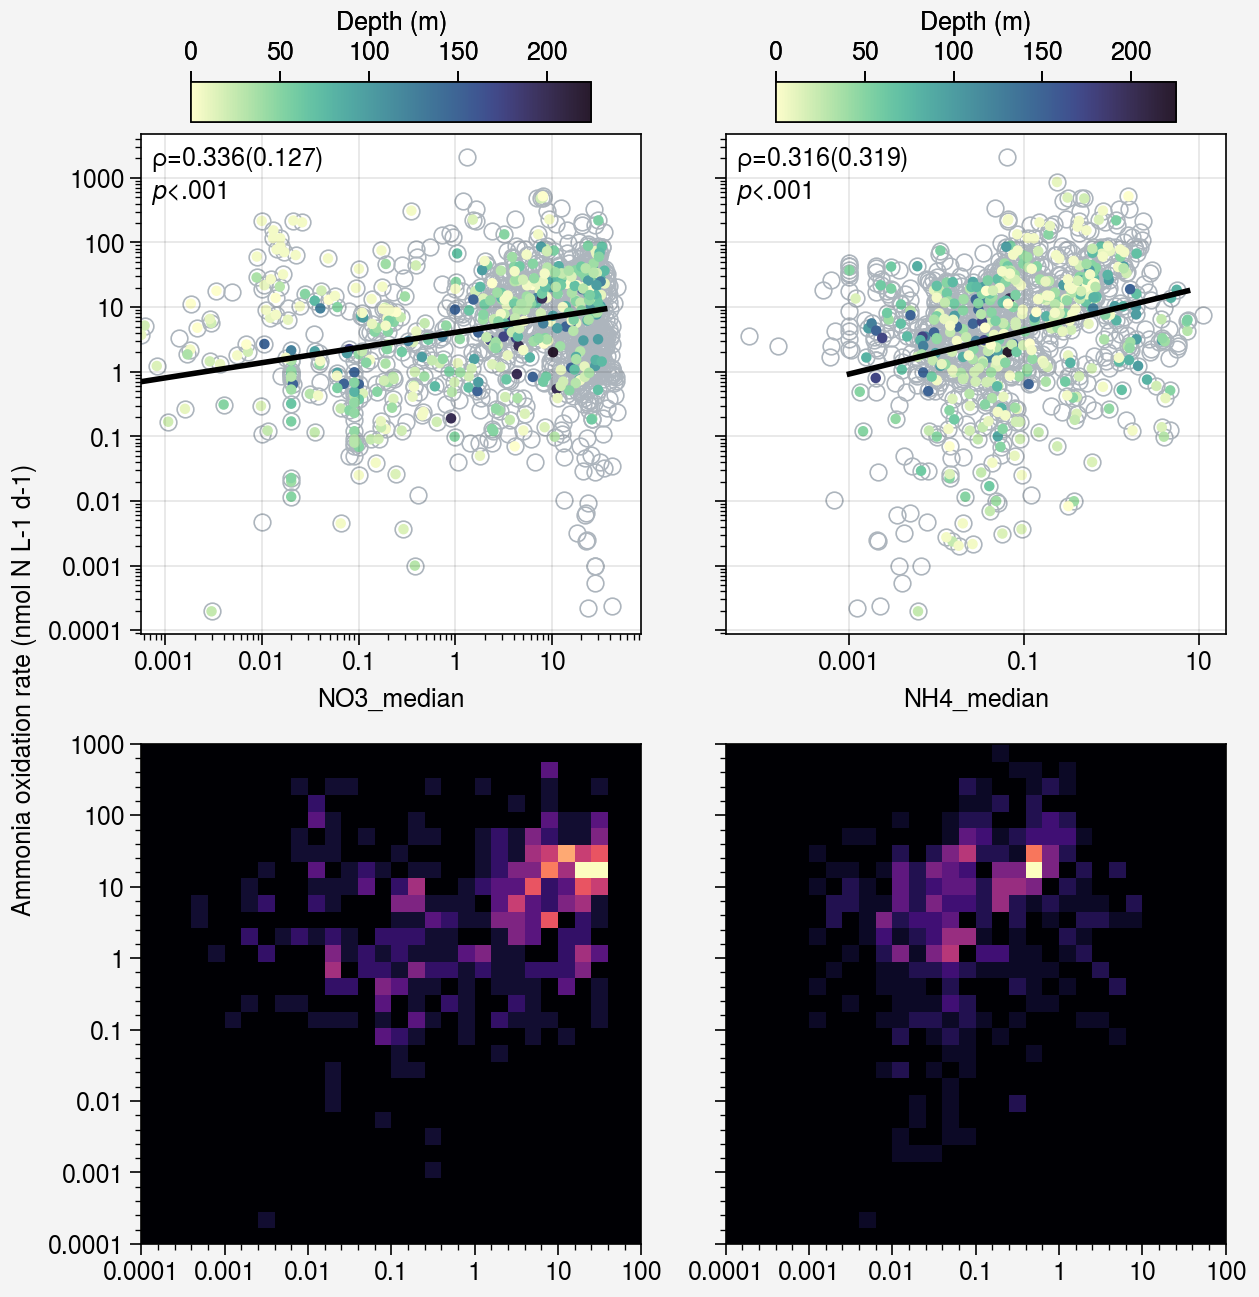

In [232]:
plot_data_ammOx_nh4 = AOM_gridded_ds.where(
    AOM_gridded_ds.depth<=thermoT_depth_da)[
        ['ammOxRate_median','NH4_median']].to_dataframe().dropna().reset_index()
    
plot_data_ammOx_no3 = AOM_gridded_ds.where(
    AOM_gridded_ds.depth<=thermoT_depth_da)[
        ['ammOxRate_median','NO3_median']].to_dataframe().dropna().reset_index()
    
plot_data_ammOx_no2 = AOM_gridded_ds.where(
    AOM_gridded_ds.depth<=thermoT_depth_da)[
        ['ammOxRate_median','NO2_median']].to_dataframe().dropna().reset_index()
    
full_data_ammOx_nh4 = AOM_gridded_ds[['ammOxRate_median','NH4_median']].to_dataframe().dropna().reset_index()
full_data_ammOx_no3 = AOM_gridded_ds[['ammOxRate_median','NO3_median']].to_dataframe().dropna().reset_index()
full_data_ammOx_no2 = AOM_gridded_ds[['ammOxRate_median','NO2_median']].to_dataframe().dropna().reset_index()

fig, axs = plot.subplots(
    ncols=2,nrows=2,
    sharex=0
)
plot_data_list = [plot_data_ammOx_no3,plot_data_ammOx_nh4]
full_data_list = [full_data_ammOx_no3,full_data_ammOx_nh4]
plot_x_list = ['NO3_median','NH4_median']
plot_y_list = ['ammOxRate_median','ammOxRate_median']
for i, (plot_data,plot_x,plot_y) in enumerate(zip(plot_data_list,plot_x_list,plot_y_list)):
    ax = axs[0,i]
    
    ### plot full data as background
    full_data = full_data_list[i]
    ax.scatter(full_data[plot_x],full_data[plot_y],
               m='o',c='none',edgecolor='gray5')
    ### full_rho and full_pval
    full_rho,full_pval = scipy.stats.spearmanr(full_data[plot_x],full_data[plot_y])
    
    m = ax.scatter(plot_data[plot_x],plot_data[plot_y],
                    c=plot_data['depth'],
                    cmap='cmo.deep',
                    s=10
    )
    ax.colorbar(m,label='Depth (m)',loc='t',length=0.8)
    
    ### calculate log10 for plot_x and plot_y
    plot_data['Log10_'+plot_x] = np.log10(plot_data[plot_x])
    plot_data['Log10_'+plot_y] = np.log10(plot_data[plot_y])
    plot_data[['Log10_'+plot_x,'Log10_'+plot_y]] = plot_data[['Log10_'+plot_x,'Log10_'+plot_y]
                                                             ].replace([np.inf,-np.inf],np.nan)
    plot_data = plot_data.dropna(subset=['Log10_'+plot_x,'Log10_'+plot_y]).reset_index(drop=True)

    ### ols fit
    ols = LinearRegression()
    X = plot_data['Log10_'+plot_x].values.reshape(-1,1)
    y = plot_data['Log10_'+plot_y]
    ols.fit(X,y)
    slope = ols.coef_[0]
    intercept = ols.intercept_
    X_pred = np.linspace(X.min(),X.max(),100)
    y_pred = ols.predict(X_pred.reshape(-1,1))
    ax.plot(10**X_pred,10**y_pred,c='k',lw=2,label='Linear fit')
    ### rho and p-value
    rho,pval = scipy.stats.spearmanr(X,y)
    pval_label = label_pvalues(pval)
    full_pval_label = label_pvalues(full_pval)
    ax.text(0.02,0.98,f'$\\rho$={rho:.3f}({full_rho:.3f})\n{pval_label}',
                transform=ax.transAxes,
                ha='left',va='top')

    ax.format(
        ylabel='Ammonia oxidation rate (nmol N L-1 d-1)',
        xscale='log',
        yscale='log',
    )
    
    ### plot heatmap in the second row
    ax = axs[1,i]
    m = ax.hist2d(plot_data['Log10_'+plot_x],plot_data['Log10_'+plot_y],
                bins=30,cmap='magma',
                range=[[-4,2],
                        [-4,3]]
                #   density=True
                )

    ax.format(
        ylim=(-4,3),
        yticklabels=['0.0001','0.001','0.01','0.1','1','10','100','1000'],
        xlim=(-4,2),
        xticklabels=['0.0001','0.001','0.01','0.1','1','10','100'],
        )
    # ax.colorbar(m,label='Count',loc='b',length=0.8)

# 4. Gridded TEX (Optional)

In [ ]:
coretop_df_full.columns

In [ ]:
new_features = ['tex_count','tex_median','tex_mean','tex_std','tex_min','tex_max']
agg_func_list = ['count','median','mean','std','min','max']

features = ['match_lon','match_lat','match_depth',
            'TEX86','RI_zhang16','region_ID',]
coretop_df_pregridded = coretop_df_full[coretop_df_full['QC_flag2']=='include'][features]
for i in range(len(new_features)):
    feature = new_features[i]
    coretop_df_pregridded[feature] = coretop_df_pregridded.groupby(['match_lon','match_lat'])['TEX86'].transform(agg_func_list[i])

coretop_df_pregridded = coretop_df_pregridded.drop_duplicates(
    subset=['match_lon','match_lat'],keep='first',
    ).rename(columns={'RI_zhang16':'ringIndex'})

coretop_gridded_ds = xr.Dataset.from_dataframe(coretop_df_pregridded.set_index(['match_lon','match_lat']))
coretop_gridded_ds = coretop_gridded_ds.rename({'match_lon':'lon','match_lat':'lat'})

### nan mask
nan_mask = coretop_gridded_ds['tex_median'].isnull()
coretop_gridded_ds = coretop_gridded_ds.where(~nan_mask,drop=True)
coretop_gridded_ds

In [ ]:
### convert depth coord to var
thermoT_depth_da_var = thermoT_depth_da.to_dataset(name='thermocline_depth')
thermoT_depth_da_var = thermoT_depth_da_var.assign_coords({'lon':thermoT_depth_da_var['lon'].values,
                                                              'lat':thermoT_depth_da_var['lat'].values}
                                                          ).reset_coords('depth', drop=True)
thermoT_depth_da_var

In [ ]:
SST_da = T_da.isel(depth=0)
SSN_da = nitrate_CMEMS_da_regrid_lld.isel(depth=0)
merge_ds_list = [SST_da.rename('sst'),SSN_da.rename('ssn'), 
                 thermoT_depth_da_var,thermoT_da,
                 thermocline_depthIntegral_T_da,
                 thermocline_nitrate_da,
                 thermocline_depthIntegral_nitrate_da,coretop_gridded_ds]

merge_ds_list_new = []
for da_ in merge_ds_list:
    ### check if 'depth' is in the coordinates
    if 'depth' in da_.coords:
        da_ = da_.reset_coords('depth', drop=True)
    elif 'time' in da_.coords:
        da_ = da_.reset_coords('time', drop=True)
    merge_ds_list_new.append(da_)
        


merged_ds = xr.merge(merge_ds_list_new)
merged_ds

In [ ]:
### linear fit between sst and tex_median
reg_data = merged_ds.stack(grid=['lat','lon'])
sel_x_param = 'thermocl_depthIntg_T'
sel_y_param = 'tex_median'
nonnan_grid_idx = (~np.isnan(reg_data[sel_x_param])) & (~np.isnan(reg_data[sel_y_param]))

ols = LinearRegression()
XX = reg_data[sel_x_param].values[nonnan_grid_idx].reshape(-1,1)
yy = reg_data[sel_y_param].values[nonnan_grid_idx]
ols.fit(XX,yy)
slope = ols.coef_[0]
intercept = ols.intercept_

pred_yy = ols.predict(XX)
# add predicted values to the dataset by creating a new variable with same dimensions as the input data
reg_data = reg_data.assign(tex_median_pred=(reg_data[sel_x_param]*0))
nan_mask = reg_data[sel_x_param].isnull()
reg_data['tex_median_pred'][nonnan_grid_idx] = pred_yy
reg_data['tex_median_pred'] = reg_data['tex_median_pred'].where(~nan_mask)
reg_data['tex_residuals'] = reg_data[sel_y_param] - reg_data['tex_median_pred']
reg_data


In [ ]:
merged_ds = reg_data.unstack('grid')
merged_ds

In [74]:
merged_ds = merged_ds.assign_attrs({
    'standard_name':'gridded coretop TEX86 data',
    'long_name':'median value of TEX86 for each grid cell with the same lat-lon dimensions as WOA23 data 0.25x0.25 degree grid',
    'units':'TEX86 [unitless], SST [degC], SSN [umol/L], depth [m], nitrate [umol/L], depthIntegral nitrate [umol/L]',
    'source':'This Study',
    })

In [ ]:
import gzip
import zlib
fpath = os.path.join(local_github_path,'netcdf_files')
fname = 'coretop_gridded_ds_011525'

### save to netcdf and compress file size
merged_ds.to_netcdf(os.path.join(fpath,fname+'.nc'),mode='w',
                    encoding={var: {'zlib': True} for var in merged_ds.data_vars})

In [ ]:
def running_mean_log10(x, y, window_size):
        # Convert x to log10 scale
        log_x = np.log10(x)
        
        # Create a DataFrame with log_x and y
        df = pd.DataFrame({'log_x': log_x, 'y': y})
        
        # Sort the DataFrame by log_x
        df = df.sort_values(by='log_x')
        
        # Calculate the running mean of y with the specified window size
        df['y_running_mean'] = df['y'].rolling(window=window_size, center=True).mean()
        
        return df['log_x'], df['y_running_mean']

def running_median_log10(x, y, window_size):
        # Convert x to log10 scale
        log_x = np.log10(x)
        
        # Create a DataFrame with log_x and y
        df = pd.DataFrame({'log_x': log_x, 'y': y})
        
        # Sort the DataFrame by log_x
        df = df.sort_values(by='log_x')
        
        # Calculate the running median of y with the specified window size
        df['y_running_median'] = df['y'].rolling(window=window_size, center=True).median()
        
        return df['log_x'], df['y_running_median']

def running_mean(x, y, window_size):
        # Create a DataFrame with x and y
        df = pd.DataFrame({'x': x, 'y': y})

        # Sort the DataFrame by x
        df = df.sort_values(by='x')

        # Calculate the running mean of y with the specified window size
        df['y_running_mean'] = df['y'].rolling(window=window_size, center=True).mean()

        return df['x'], df['y_running_mean']
    
fig, axs = plot.subplots(width=6)

plot_data = merged_ds[['thermocl_depthIntg_T','thermocl_depthIntg_nitrate',
                       'tex_median','tex_residuals']].to_dataframe().reset_index().dropna(how='any')

ax = axs[0]
sel_x_param = 'thermocl_depthIntg_nitrate'
sel_y_param = 'tex_residuals'
plot_x = plot_data[sel_x_param]
plot_y = plot_data[sel_y_param]

### spearman rho and pval
rho, pval = spearmanr(plot_x,plot_y)
pval_label = label_pvalues(pval)
ax.text(0.98,0.98,f'N={len(plot_x)}\n$\\rho$: {rho:.4f}\n{pval_label}\nfull gridded data',
        transform=ax.transAxes,ha='right',va='top')

### linear fit between log(nitrate) and TEX residuals
pre_reg_data = plot_data[[sel_x_param,sel_y_param]].dropna()
pre_reg_data = pre_reg_data.sort_values(by=sel_x_param).reset_index(drop=True)

### find the optimal running mean window size to get the highest spearman rho
window_sizes = np.arange(10,201,5)
rho_list = []
for window_size in window_sizes:
        log_x, y_running_mean = running_mean_log10(pre_reg_data[sel_x_param],pre_reg_data[sel_y_param],window_size)
        xpos_min_y_running_mean = 10**log_x[y_running_mean.idxmin()]
        
        test_reg_data = pre_reg_data.dropna(how='any',subset=[sel_x_param,sel_y_param])
        test_reg_data = test_reg_data[test_reg_data[sel_x_param]<xpos_min_y_running_mean]
        
        
        XXX = test_reg_data[sel_x_param]
        YYY = test_reg_data[sel_y_param]
        
        rho, pval = stats.spearmanr(XXX,YYY)
        rho_list.append(rho)
best_window_size = window_sizes[np.argmin(rho_list)]

### find x value with minimum running mean of y
log_x, y_running_mean = running_mean_log10(pre_reg_data[sel_x_param],pre_reg_data[sel_y_param],best_window_size)
ax.axvline(10**log_x[y_running_mean.idxmin()],color='gray5',ls='--',lw=1,zorder=0)

vline_xpos = 10**log_x[y_running_mean.idxmin()]
ax.text(vline_xpos+0.1,0.95,f'{vline_xpos:.2f}',transform=ax.get_xaxis_transform(),
        ha='left',va='top')
ax.plot(10**log_x,y_running_mean,color='teal9',lw=1)

plot_x = plot_data[plot_data[sel_x_param]<vline_xpos][sel_x_param]
plot_y = plot_data[plot_data[sel_x_param]<vline_xpos][sel_y_param]
ax.scatter(plot_x,plot_y,s=20,marker='.',color='gray7',label='Coretops')

plot_x_exclude = plot_data[plot_data[sel_x_param]>vline_xpos][sel_x_param]
plot_y_exclude = plot_data[plot_data[sel_x_param]>vline_xpos][sel_y_param]
ax.scatter(plot_x_exclude,plot_y_exclude,
            s=20,marker='x',color='gray5',
            label='Excluded data',zorder=0)

reg_data = pre_reg_data[pre_reg_data[sel_x_param]<vline_xpos]

reg_data['log_'+sel_x_param] = np.log10(reg_data[sel_x_param])
reg_data['log_'+sel_x_param] = reg_data['log_'+sel_x_param].replace([-np.inf,np.inf],np.nan)
reg_data = reg_data.dropna(how='any',subset=[sel_x_param,sel_y_param,'log_'+sel_x_param])
ols = sm.OLS(reg_data[sel_y_param],sm.add_constant(reg_data['log_'+sel_x_param])).fit()
plot_x_fit = np.linspace(reg_data['log_'+sel_x_param].min(),reg_data['log_'+sel_x_param].max(),100)
plot_y_fit = ols.predict(sm.add_constant(plot_x_fit))
ax.plot(10**plot_x_fit,plot_y_fit,c='deep red',
        label='TEX residuals')

rho, pval = spearmanr(reg_data[sel_x_param],reg_data[sel_y_param])
pval_label = label_pvalues(pval)
ax.text(0.02,0.02,f'N={len(reg_data)}\n$\\rho$: {rho:.3f}\n{pval_label}\n(data with nitrate < {vline_xpos:.2f} $\mu$mol/L)',
        transform=ax.transAxes,
        ha='left',va='bottom')

ax.format(
    xscale='log'
)